In [1]:
 #from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from tensorflow.keras import backend as K
import cv2, numpy as np
import glob
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu 
import keras as keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,add,Reshape

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses
from tensorflow.keras.layers import  Layer,Activation, Lambda, MaxPooling2D, UpSampling2D, Conv2DTranspose, SpatialDropout2D
import os
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf
from tensorflow.keras.losses import mse, binary_crossentropy


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from tensorflow.keras import backend as K
from pathlib import Path
from keras import objectives

from tensorflow.keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
from tensorflow.keras.datasets import  mnist, fashion_mnist

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model

Using TensorFlow backend.


In [2]:
a=[1,2,3]
#a[:,-1]

In [3]:
intermediate_dim = 3136
ch_d=[7, 7, 64]

In [4]:

img_size = 28
num_channels = 1
latent_space_dim = 5

inp = Input(shape=(img_size, img_size, num_channels))

x1=Conv2D(1, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(inp)
x2=Conv2D(32, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(x1)

x3=Conv2D(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(x2)
 
x4=Conv2D(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(x3)

x4=Conv2D(128, kernel_size=3, strides=4, padding='same',activation="relu", kernel_initializer = 'he_normal')(x4)

       
fl=  Flatten()(x4)

encoder_mu =  Dense(units=latent_space_dim)(fl)
mu=encoder_mu
rho= Dense(units=1, activation='tanh')(fl)

logs=Dense(units=1, activation='relu')(fl)
logs=K.log(logs+1e-7)
#z= Lambda(sampling_rho )([encoder_mu, rho,logs])

epsilon = K.random_normal(shape=K.shape(rho), mean=0.0, stddev= .05)

z_q=epsilon*K.sqrt(K.exp(logs))
shn = K.int_shape(z_q)[1:]

f= K.max(z_q)
for i in range(0,4):
    f= K.max(z_q)
    addenum = rho * f   + K.random_normal(shape=K.shape(rho), mean=0.0, stddev=.05)*K.sqrt(K.exp(logs))
    z_q =  Concatenate( )([addenum,z_q])

z_q  = add([z_q ,  mu])
# print(len(shn ) )
# print(f )


d1= Dense(units=intermediate_dim )(z_q)
d_reshape = Reshape(target_shape=ch_d)(d1)
d4=Conv2DTranspose(256, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(d_reshape)
 
d4=Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(d4)
 

d3=Conv2DTranspose(64, kernel_size=3, strides=1, padding='same',activation="relu", kernel_initializer = 'he_normal')(d4)
 


d2=Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',activation="relu", kernel_initializer = 'he_normal')(d3)
 

d1=Conv2DTranspose(1, kernel_size=3, strides=1, padding='same',activation="sigmoid", kernel_initializer = 'he_normal')(d2)


vae = Model(inp, d1)


vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 1)    10          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
def bc(x, t_decoded):
    return K.mean(K.sum(K.binary_crossentropy(K.batch_flatten(x),  K.batch_flatten(t_decoded)), axis=1)) 

def m_loss(y_true,y_pred):
    return K.mean(K.square(y_pred-y_true), axis=0)

In [6]:
#reconstruction_loss = K.mean( binary_crossentropy(inp, d1))
reconstruction_loss = ( bc(inp, d1))

 
ms = (m_loss(inp, d1))

kl_loss =   0.5 *  ((K.sum (K.square(mu)))+ -(latent_space_dim*logs)-
                                    (latent_space_dim-1)*K.log(1-K.square(rho)+1e-7)+ latent_space_dim*(K.exp(logs)-1))


kl_loss =K.mean( (kl_loss ))




vae_loss =  (kl_loss+ reconstruction_loss+ms   )

vae.add_loss(vae_loss)

In [7]:
vae.compile(optimizer='adam')

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [9]:
vae.fit(x_train, epochs=200, batch_size=64, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 20s 332us/sample - loss: 142.5263 - val_loss: 125.2393
Epoch 2/200
60000/60000 [==============================] - 17s 276us/sample - loss: 122.3676 - val_loss: 120.0594
Epoch 3/200
60000/60000 [==============================] - 17s 276us/sample - loss: 118.9330 - val_loss: 117.8154
Epoch 4/200
60000/60000 [==============================] - 16s 270us/sample - loss: 117.0327 - val_loss: 116.1405
Epoch 5/200
60000/60000 [==============================] - 16s 267us/sample - loss: 115.8120 - val_loss: 115.7285
Epoch 6/200
60000/60000 [==============================] - 16s 273us/sample - loss: 114.7413 - val_loss: 115.2287
Epoch 7/200
60000/60000 [==============================] - 16s 271us/sample - loss: 113.9394 - val_loss: 114.3351
Epoch 8/200
60000/60000 [==============================] - 16s 273us/sample - loss: 113.2574 - val_loss: 114.2253
Epoch 9/200
60000/60000 [=============

Epoch 72/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.7771 - val_loss: 111.8735
Epoch 73/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.8246 - val_loss: 111.6542
Epoch 74/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.7843 - val_loss: 111.6812
Epoch 75/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.7317 - val_loss: 111.3424
Epoch 76/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.6413 - val_loss: 111.9425
Epoch 77/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.5960 - val_loss: 112.4798
Epoch 78/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.6025 - val_loss: 112.0345
Epoch 79/200
60000/60000 [==============================] - 16s 267us/sample - loss: 103.4925 - val_loss: 112.1732
Epoch 80/200
60000/60000 [==============================] - 16s 267us/sample - l

KeyboardInterrupt: 

In [10]:
vae.save_weights('rho_vae.h5py'  )

In [11]:
vae.load_weights('rho_vae.h5py'  )

In [12]:
encoder_input = np.expand_dims(x_test[36], axis = 0)

In [13]:
decoded_output = vae.predict(encoder_input)[0]
decoded_output.shape

(28, 28, 1)

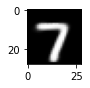

In [14]:
ot=np.squeeze(decoded_output )
plt.figure(figsize=(1,1)) 
plt.imshow(ot, cmap = 'gray')
plt.show()

In [15]:
import random


In [16]:
random.randint(0, 9999)

5890

In [17]:
from scipy.stats import norm
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

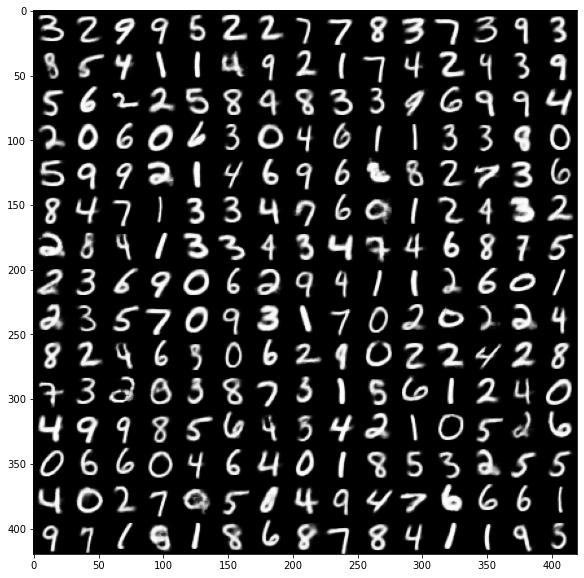

In [20]:
n=30
figsize=15
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        encoder_input = np.expand_dims(x_test[random.randint(0, 1999)], axis = 0)
        x_decoded = vae.predict(encoder_input)
    
        digit = np.squeeze(x_decoded[0])
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()  